In [1]:
#import important liberies
import pandas as pd
import numpy as np

#visualisation liberies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#.rdata file reader
import pyreadr

#zipfile extract
import zipfile as zp

#sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

# # Import the required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import sklearn

In [3]:
df_ff = pd.read_csv("dataset/fault_free_training.csv",index_col="Unnamed: 0")
df_faulty = pd.read_csv("dataset/faulty_training.csv",index_col="Unnamed: 0")
df = pd.concat([df_faulty,df_ff])

def wrangle(df, simulation):
    reduced_data =df[(df['simulationRun'] >simulation[0] ) & (df['simulationRun'] <simulation[1] ) & (df['sample']>20)]
    reduced_data = reduced_data[reduced_data['faultNumber'] != 3]
    reduced_data = reduced_data[reduced_data['faultNumber'] != 9]
    reduced_data = reduced_data[reduced_data['faultNumber'] != 15]
    return reduced_data

reu_df = wrangle(df,simulation=[1,20])

In [10]:
sc = StandardScaler()
sc.fit(reu_df.iloc[:,3:])

X = sc.transform(reu_df.iloc[:,3:])
Y = reu_df['faultNumber']
le = LabelEncoder()
Y_enc = le.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42)

In [6]:
import joblib

logreg = joblib.load('model/logistic_regression_model.pkl')
dt = joblib.load('model/decision_tree_model.pkl')
rf = joblib.load('model/random_forest_model.pkl')
nb = joblib.load('model/naive_bayes_model.pkl')
knn = joblib.load('model/knn_model.pkl')
xg = joblib.load('model/xgboost_model.pkl')
sc = joblib.load('model/standard_scalar.pkl')

# Explainable AI
## Local
### Lime

In [7]:

import lime
import lime.lime_tabular
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=reu_df.columns[3:], training_labels= y_train, discretize_continuous=True)
idx=1
y_pred = xg.predict(np.expand_dims(x_test[idx], axis=0))
# y_pred = enc.inverse_transform(y_pred)[0][0]
print(f"Predicted fault is {y_pred}")
exp = lime_explainer.explain_instance(x_test[idx], xg.predict_proba, num_features=10, top_labels=1)
note = exp.show_in_notebook(show_table=True, show_all=False)



Predicted fault is [7]


### Shap


In [11]:

import shap
shap.initjs()
# explain the model's predictions using SHAP
explainer = shap.KernelExplainer(xg.predict_proba, x_train[::100])

idx_sample = 34
shap_values = explainer.shap_values(x_test[idx_sample])
sampled_test_data = x_test[idx_sample]
sampled_test_labels = y_test[idx_sample]

print(f"the predicted class is: {xg.predict([sampled_test_data])}")
cls_index =  sampled_test_labels
print(f"the Actual class is: {cls_index}")

for fault_cls in range(0,18):
    print(f"Force plot for fault class: {fault_cls}")
    display(shap.force_plot(explainer.expected_value[fault_cls], shap_values[fault_cls],sampled_test_data ))


Using 1245 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


the predicted class is: [15]
the Actual class is: 15
Force plot for fault class: 0


Force plot for fault class: 1


Force plot for fault class: 2


Force plot for fault class: 3


Force plot for fault class: 4


Force plot for fault class: 5


Force plot for fault class: 6


Force plot for fault class: 7


Force plot for fault class: 8


Force plot for fault class: 9


Force plot for fault class: 10


Force plot for fault class: 11


Force plot for fault class: 12


Force plot for fault class: 13


Force plot for fault class: 14


Force plot for fault class: 15


Force plot for fault class: 16


Force plot for fault class: 17


#### Tree explainer


In [12]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xg)


shap_values = explainer.shap_values(x_test[::50])
# ntree_limit is deprecated, use `iteration_range` or model slicing instead.
# x_test[::50]
# Visualize the SHAP values for a single example
sampled_test_data = x_test[::50]
sampled_test_labels = y_test[::50]

sample_idx = 45

print(f"the predicted class is: {xg.predict(sampled_test_data[[sample_idx]])}")
cls_index =  sampled_test_labels[sample_idx]
print(f"the Actual class is: {cls_index}")

for fault_cls in range(0,18):
    print(f"Force plot for fault class: {fault_cls}")
    display(shap.force_plot(explainer.expected_value[fault_cls], shap_values[fault_cls][sample_idx],sampled_test_data[sample_idx],feature_names=reu_df.columns[3:]))


[20:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


the predicted class is: [6]
the Actual class is: 6
Force plot for fault class: 0


Force plot for fault class: 1


Force plot for fault class: 2


Force plot for fault class: 3


Force plot for fault class: 4


Force plot for fault class: 5


Force plot for fault class: 6


Force plot for fault class: 7


Force plot for fault class: 8


Force plot for fault class: 9


Force plot for fault class: 10


Force plot for fault class: 11


Force plot for fault class: 12


Force plot for fault class: 13


Force plot for fault class: 14


Force plot for fault class: 15


Force plot for fault class: 16


Force plot for fault class: 17


Ignoring `palette` because no `hue` variable has been assigned.


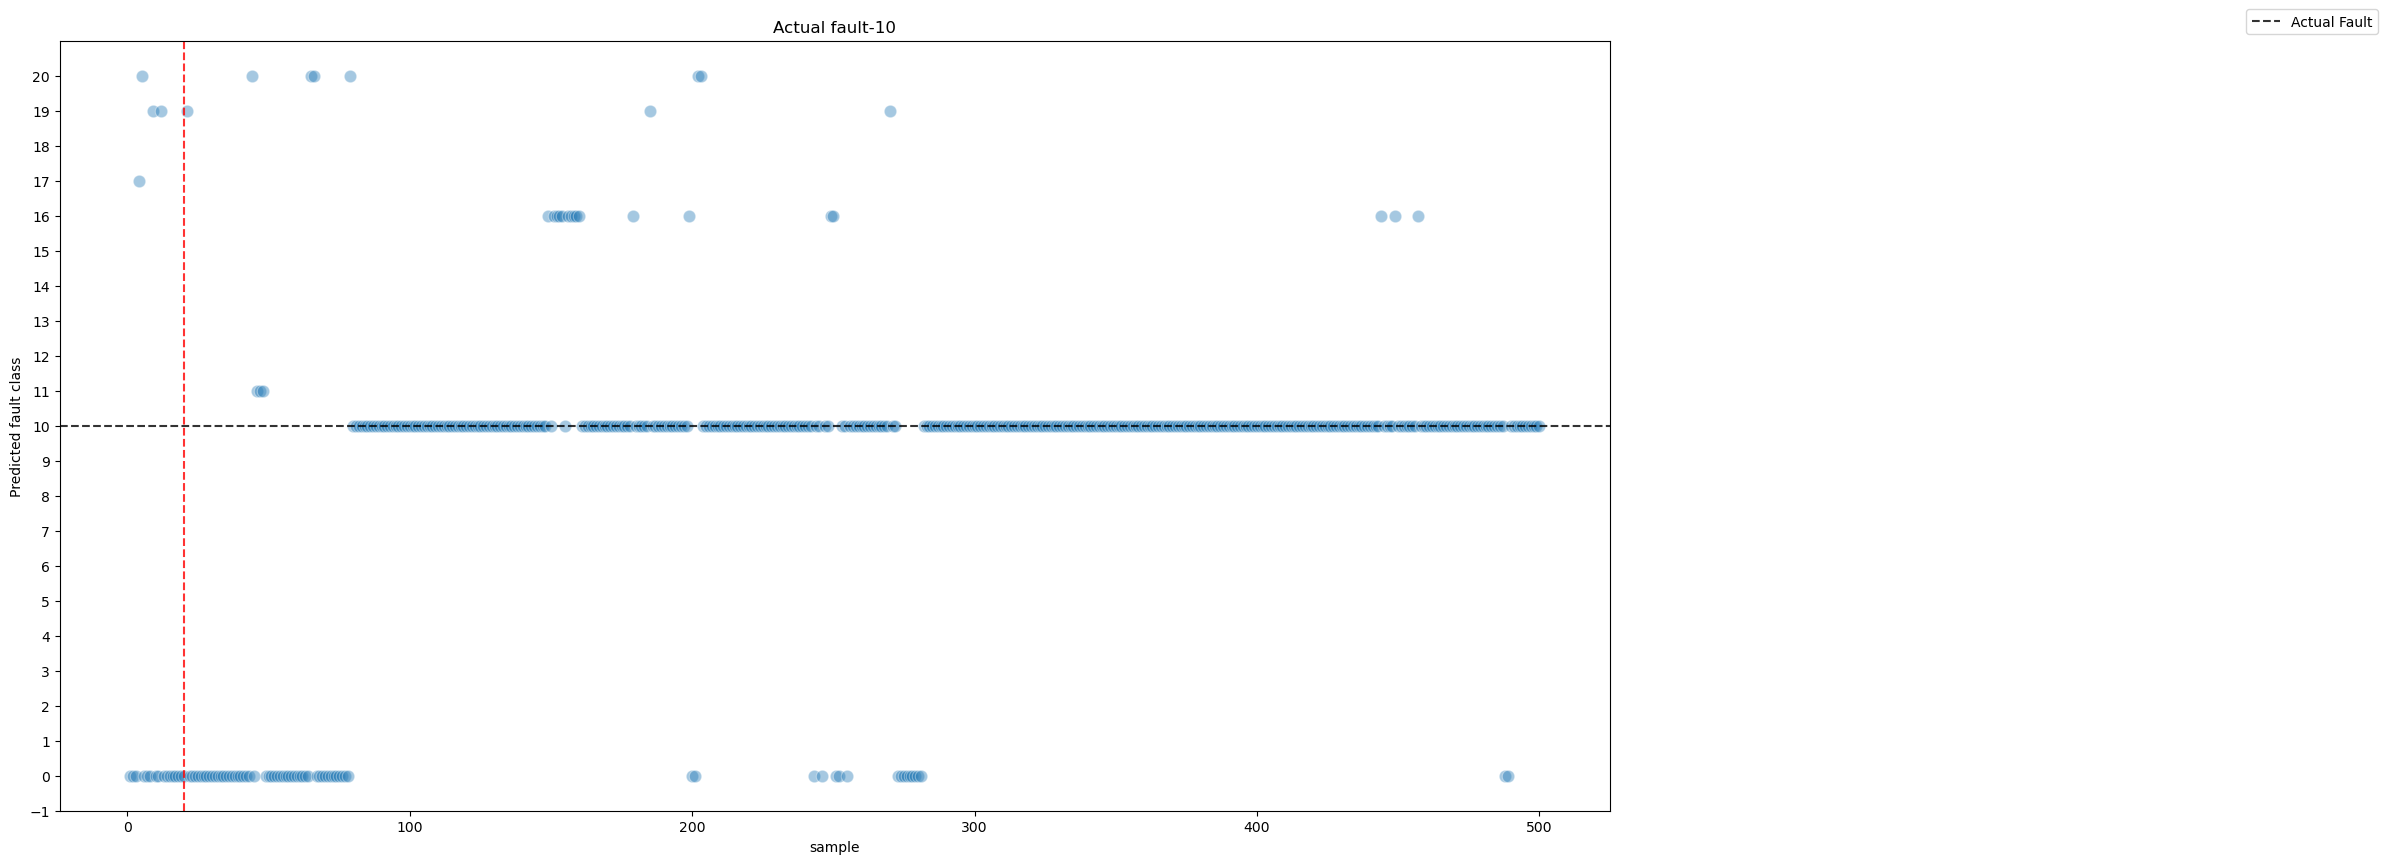

In [13]:
F_num=10

df_new= df[(df['faultNumber']==F_num) & (df['simulationRun']==1)].copy()
x_new = df_new.iloc[:,3:]
x_new = sc.transform(x_new)
x_new = pd.DataFrame(x_new, columns=df_new.iloc[:,3:].columns)


# # Generate random numbers and append to x_new
# rand_nums = np.random.rand(len(x_new), 1)
# x_new = np.hstack((x_new, rand_nums))

# generate shapely values
shap_values_sample = explainer.shap_values(x_new)


y_pred = xg.predict(x_new)
# shap values for this fault class
data = shap_values_sample[le.transform([F_num])[0]]

y_pred = le.inverse_transform(y_pred)


f, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=df_new['sample'],y=y_pred,palette="coolwarm",s=80,alpha=0.4)

plt.axvline(20,c='r',alpha=0.8,linestyle ='--')
plt.axhline(F_num,c='black',alpha=0.8,label='Actual Fault',linestyle ='--')
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.ylabel('Predicted fault class')
plt.title(f'Actual fault-{F_num}')
plt.yticks(np.arange(-1,21,1))
plt.show()


### Saliancy Feature
## Global Feature importance
### Premutation

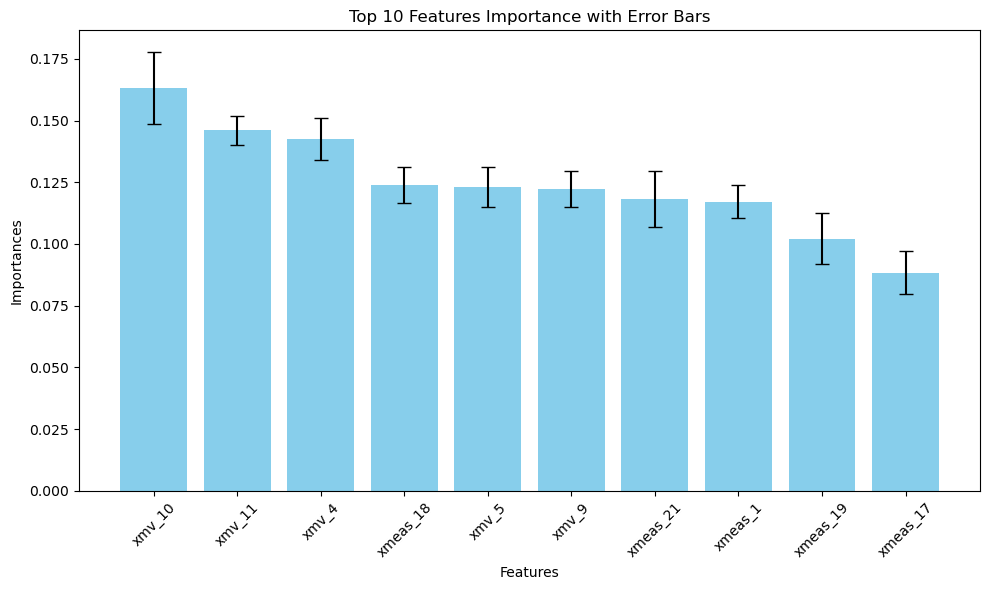

In [23]:
 
from sklearn.inspection import permutation_importance
result = permutation_importance(xg, x_test[::50], y_test[::50], n_repeats=10, random_state=42)

# Get feature importances and standard deviations
importances = result.importances_mean
std_devs = result.importances_std
# Print feature importances
# for feature, importance, std_dev in zip(reu_df.iloc[:,3:].columns, importances, std_devs):
#     print(f"{feature}: {importance:.4f} ± {std_dev:.4f}")

res = pd.DataFrame(importances, columns=["Importances"])
res["std_dev"] = std_devs
res["features"] = reu_df.iloc[:,3:].columns
res["permutation_importance"] = res.Importances.round(5).astype("str") + "±" + res.std_dev.round(5).astype("str")
res.sort_values("Importances",inplace=True,ascending=False)
# str(res.Importances) + "±" + str(res.std_dev)
plt.figure(figsize=(10, 6))
plt.bar(res['features'].head(10), res['Importances'].head(10), yerr=res['std_dev'].head(10), capsize=5, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('Top 10 Features Importance with Error Bars')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()



### Partial dependence


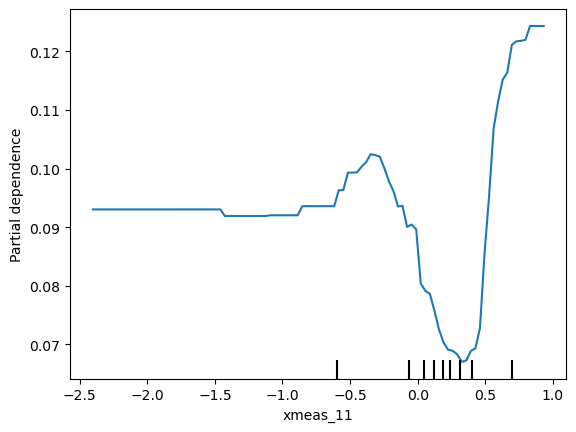

In [25]:

from sklearn.inspection import PartialDependenceDisplay

feat_name = 'xmv_10'
PartialDependenceDisplay.from_estimator(xg, x_test[::50],features=[10], feature_names=reu_df.columns[3:],target=17)
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


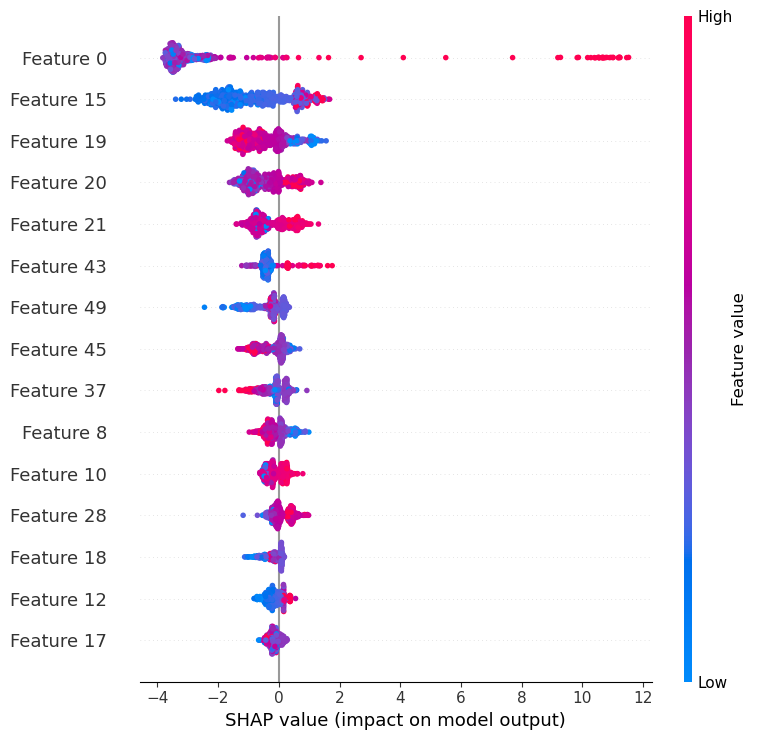

In [16]:
shap.summary_plot(shap_values[1], x_test[::50], max_display=15)

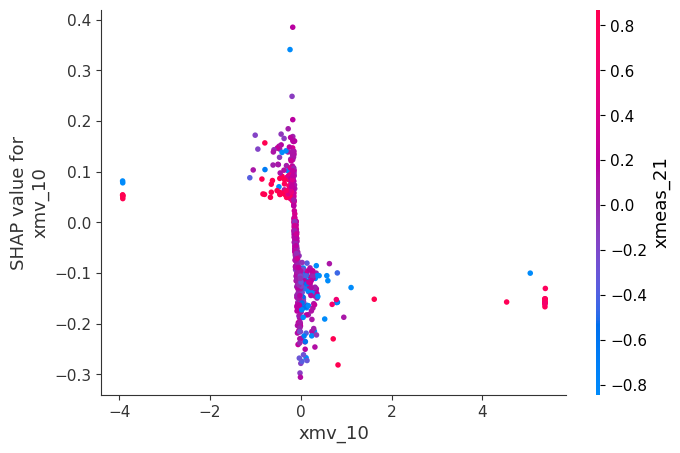

In [19]:
shap.dependence_plot("xmv_10", shap_values[1], x_test[::50], feature_names=reu_df.columns[3:])

In [ ]:

# from sklearn import tree
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dt, 
#                    feature_names=reu_df.columns[3:],
#                    filled=True)

### From above analysis, XGB and Random forest Performs well.
### Metrics:

In this series, we will use accuracy as the primary metric for evaluating the performance of the different machine learning algorithms. We will update the table as we evaluate the performance of other algorithms in the subsequently.


Average accuracy score obtained for each method, excluding fault No. 9 and 15 (**No feature were Dropped, all 52 sensor measurements were used**)

| Method                                    |Accuracy  |
|-----------------------------------------  |----------|
| XG Boost                                  |  0.924  |
| Random Forest                           |  0.895   |
| Naive Bayes                                   |  0.652   |
| KNN                               |  0.464   |
| Decision Tree                                  |  0.827   |
| Logistic Regression                                  |  0.695   |

# communicating result
## For Non-technical
### Real time Fault Prediction

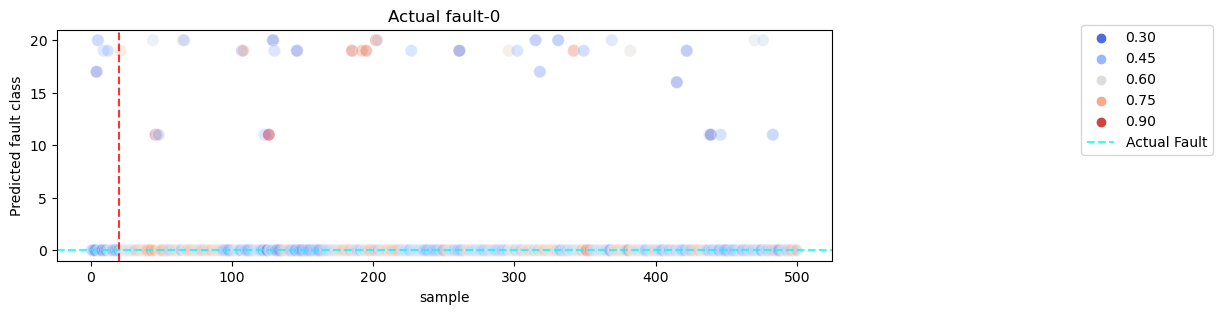

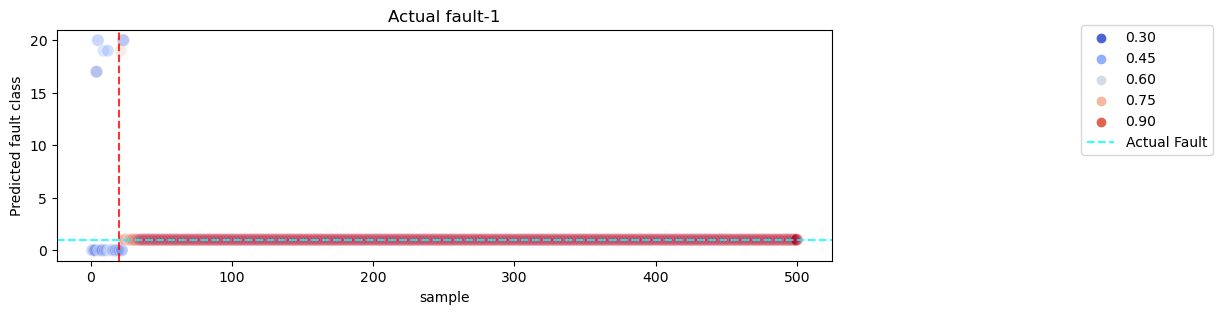

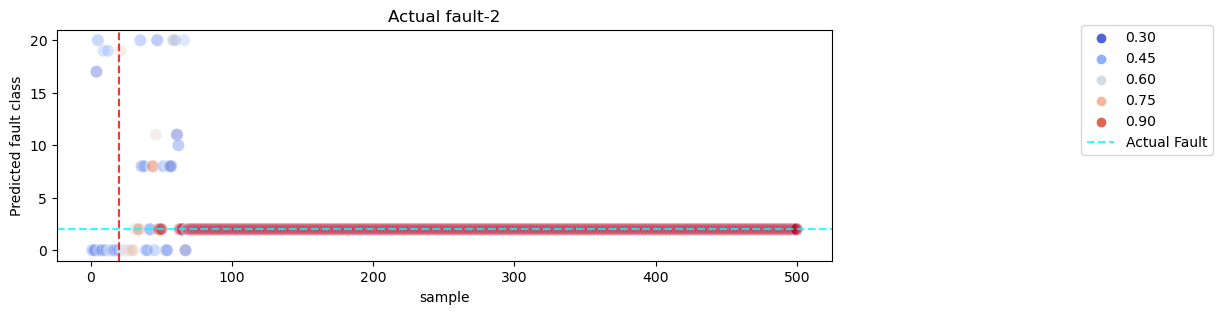

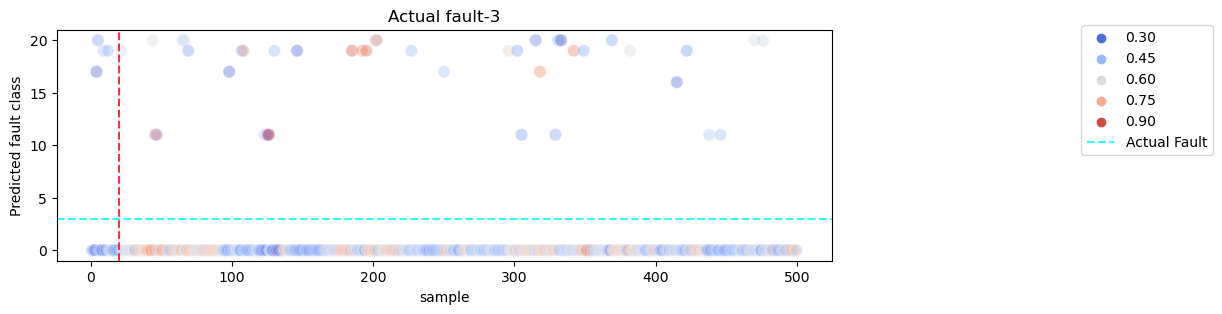

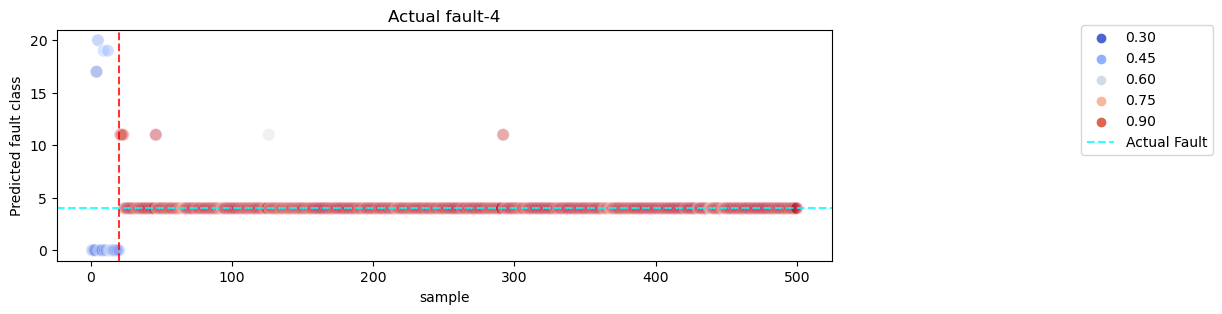

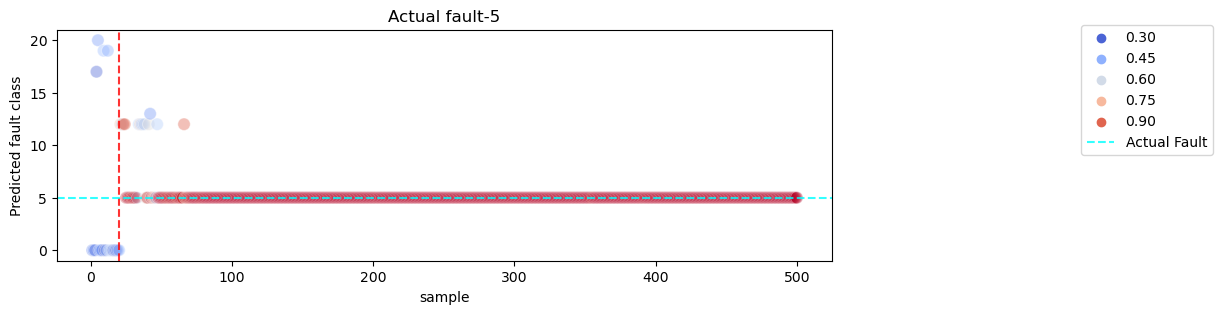

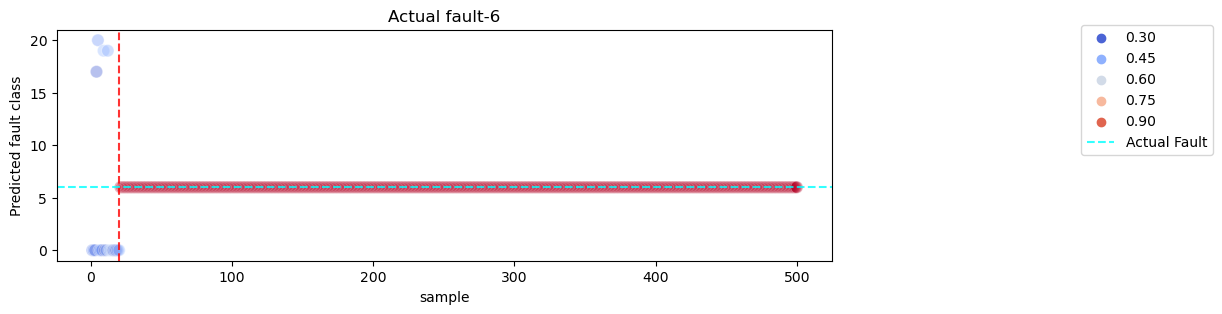

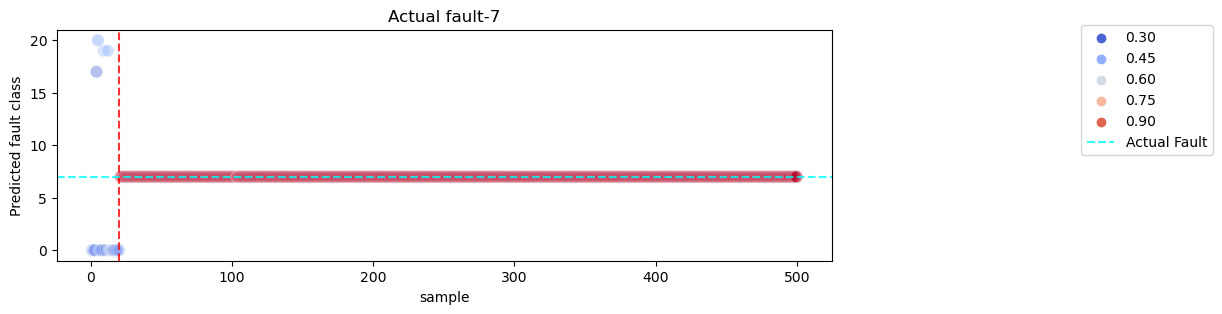

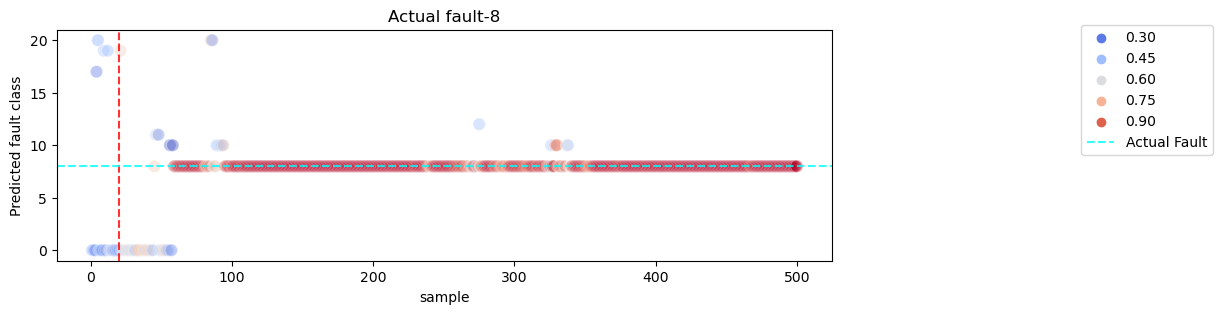

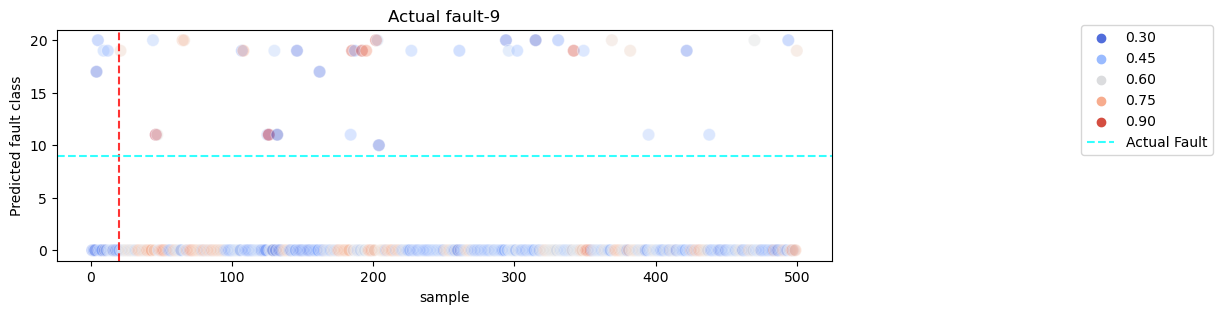

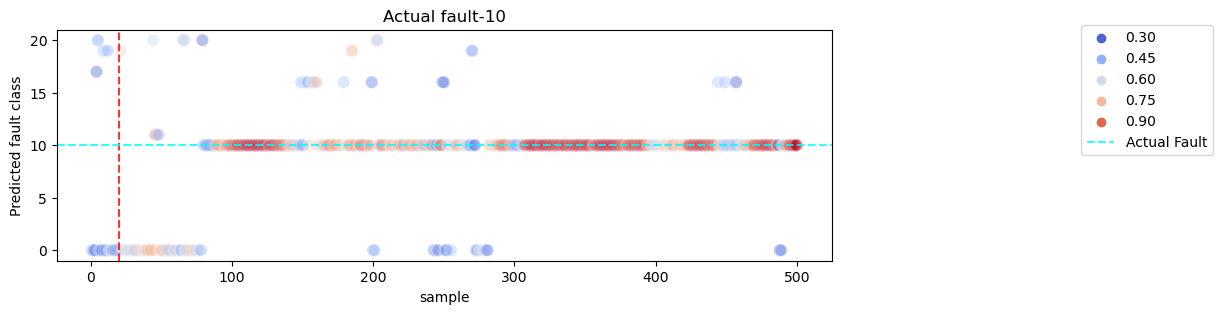

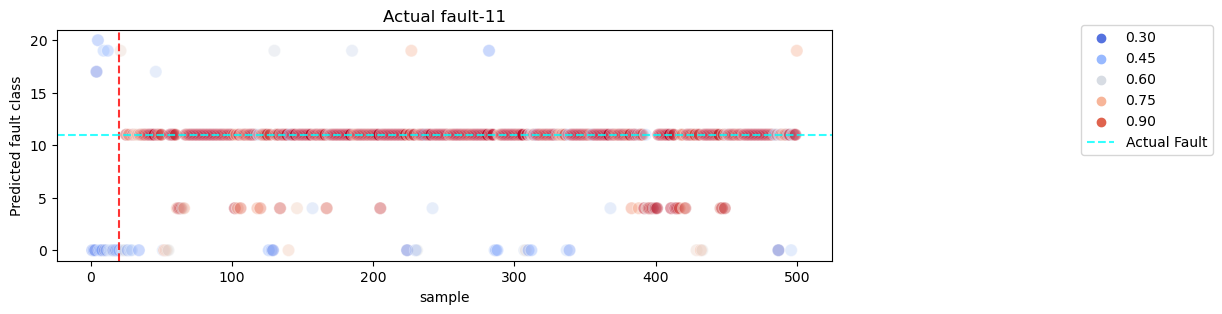

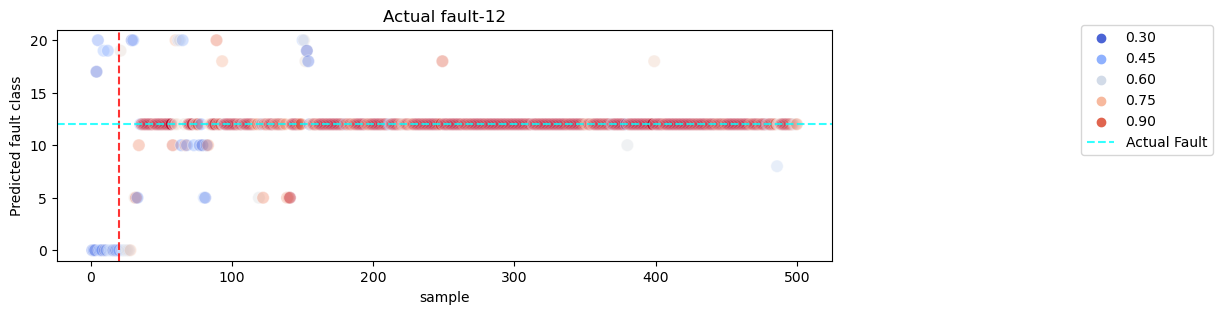

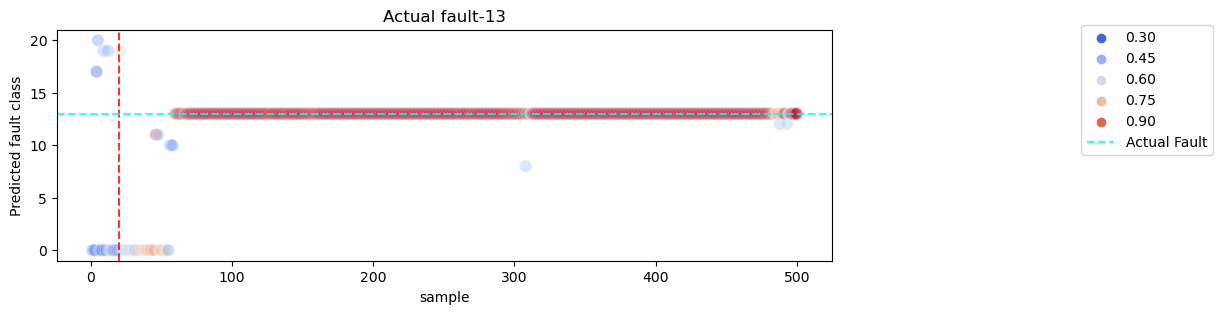

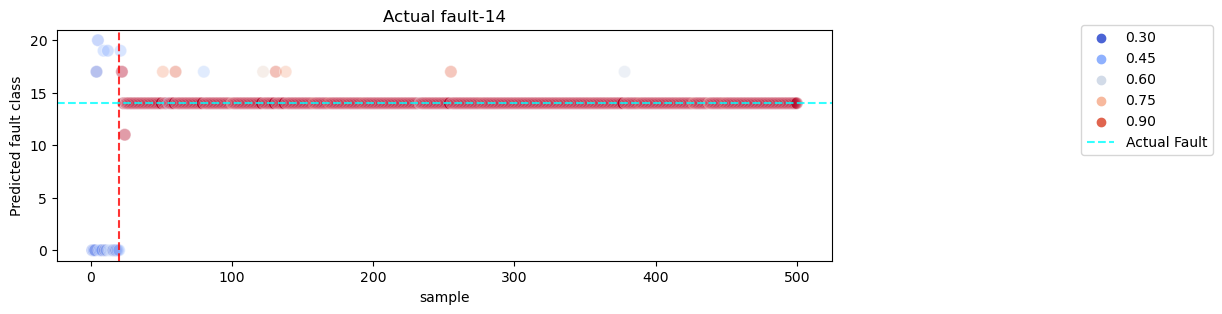

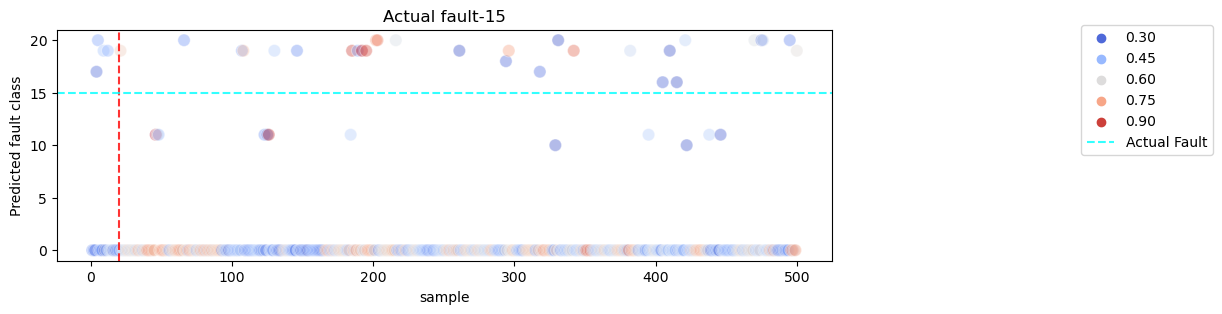

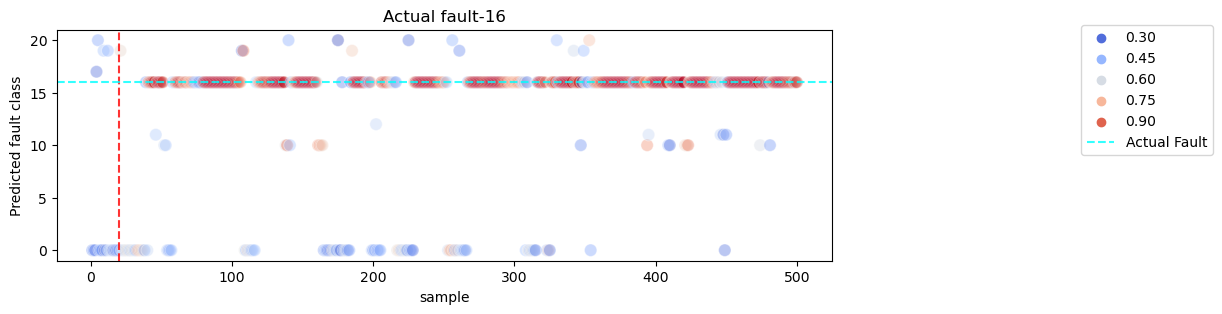

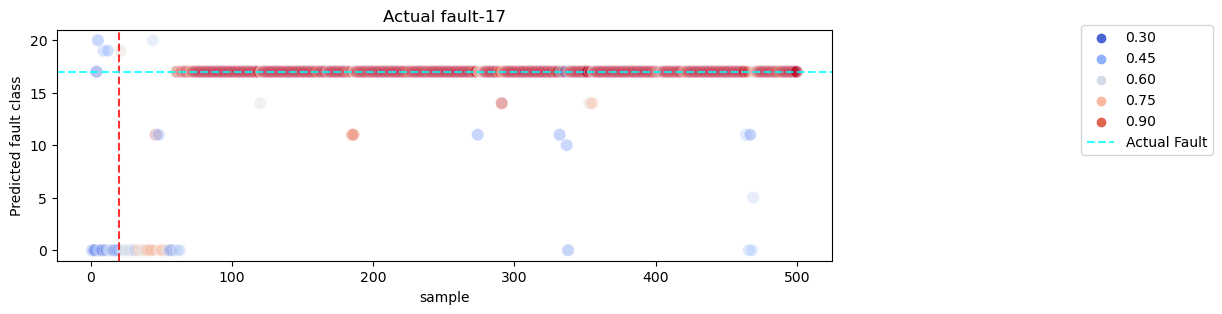

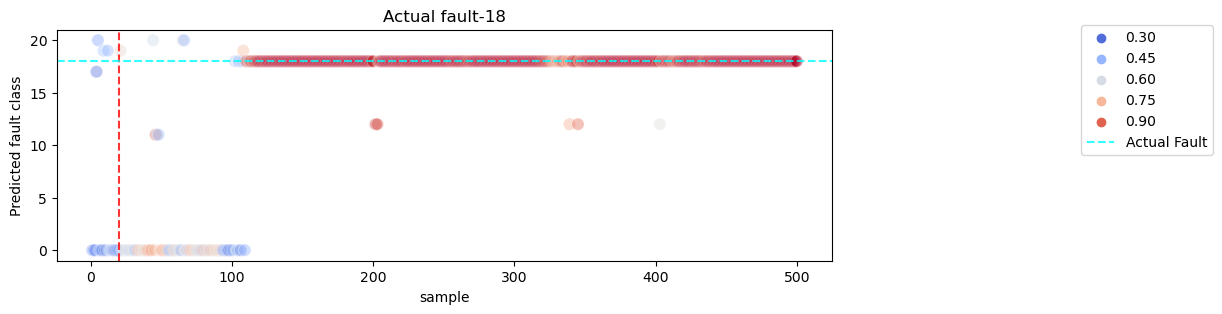

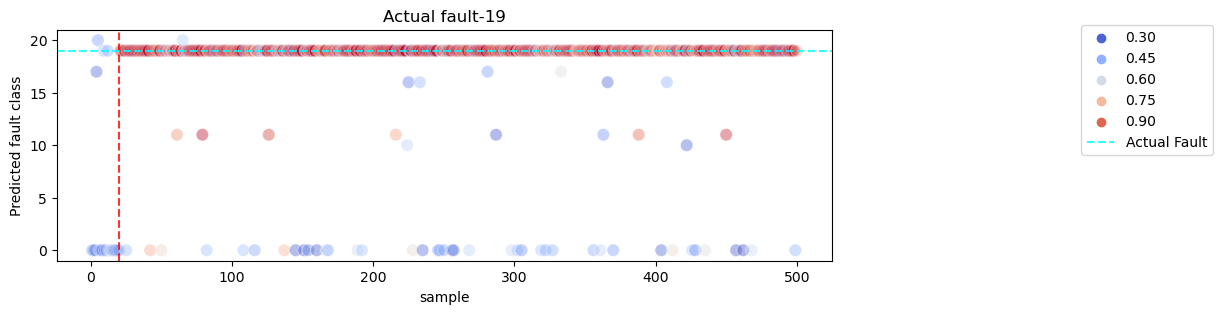

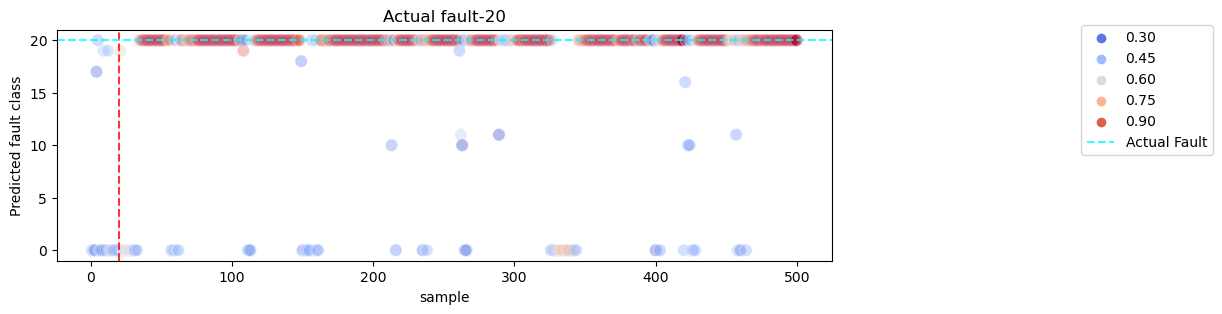

In [22]:
for F_num in range(0,21):
    df_new= df[(df['faultNumber']==F_num) & (df['simulationRun']==1)].copy()
    x_new = df_new.iloc[:,3:]
    x_new = sc.transform(x_new)
    y_pred = xg.predict(x_new)
    y_pred = le.inverse_transform(y_pred)
    y_proba = np.max(xg.predict_proba(x_new),axis=1)

    f, ax = plt.subplots(figsize=(10,3))
    sns.scatterplot(x=df_new['sample'],y=y_pred,hue=y_proba,palette="coolwarm",s=80,alpha=0.4)
    plt.axvline(20,c='r',alpha=0.8,linestyle ='--')
    plt.axhline(F_num,c='cyan',alpha=0.8,label='Actual Fault',linestyle ='--')
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    plt.ylabel('Predicted fault class')
    plt.title(f'Actual fault-{F_num}')
    plt.show()

### Visualize diffrent types of faults

In [ ]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from explainerdashboard.datasets import titanic_embarked, feature_descriptions
feature_descriptions
type(le.classes_)
ls = list(set(y_test))
ls1 = [str(n) for n in ls] 
ls1
explainer = ClassifierExplainer(xg, x_test, y_test,  
                                descriptions=X_dict,
                                labels=ls1,
                                pos_label=ls1[0]
                                )

ExplainerDashboard(explainer).run()
4 * np.random.rand(20) - 2